In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import shap
from sklearn import datasets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, r2_score, roc_auc_score
from sklearn.model_selection import train_test_split
import seaborn as sns
from TreeModelsFromScratch.DecisionTree import DecisionTree
from TreeModelsFromScratch.RandomForest import RandomForest
from TreeModelsFromScratch.SmoothShap import verify_shap_model, smooth_shap, GridSearchCV_scratch, cross_val_score_scratch, conf_int_ratio_mse_ratio
from TreeModelsFromScratch.datasets import DATASETS_CLASSIFICATION, DATASETS_REGRESSION, DATASET_PATH
from imodels.util.data_util import get_clean_dataset
import os
from sklearn.metrics import mean_squared_error
from datetime import datetime
import pickle
from tqdm import tqdm, trange
import numbers
from copy import deepcopy
import scipy.stats as st

In [3]:
#load JS vis in the notebook for shap plots
shap.initjs() 

In [4]:
#for storing results
data_path = os.path.join(os.path.dirname(os.getcwd()),"data","test")
today_str = datetime.today().strftime("%Y%m%d")

# Nodewise difference MSE
As a proof of concept we use a train test split instead of inbag-oob samples to increase the oob sample size, to mitigate risk of small sample sizes in deep nodes

## Load titanic dataset

In [5]:
data = pd.read_csv("../raw_data/titanic/titanic_train.csv")
data = data[data["Age"].notnull()] #filter rows which are nan
data["Sex"] = pd.get_dummies(data["Sex"])["female"] #dummy code sex (1==Female)

In [6]:
X = data[['Age', 'Pclass', 'Sex', 'PassengerId']]
y = data["Survived"].astype("float")
X, X_holdout, y, y_houldout = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, shuffle=True, random_state=42)

## Idea 1: Train-test split instead of Inbag and OOB samples

### Create function for nodewise shrinkage

In [47]:
def conf_int_mse_ratio_scr(pop_1, pop_2, node_val_inbag, type="regression", alpha=0.05):
    '''Calculate shrinkage parameter based on confidence interval based on 2-sample difference in MSE'''

    # number of samples per population
    n1 = len(pop_1) #pop1 = y_true_inbag
    n2 = len(pop_2) #pop2 = y_true_oob

    #full array of node vals for MSE calc
    node_val_pop1 = np.full(pop_1.shape, node_val_inbag)
    node_val_pop2 = np.full(pop_2.shape, node_val_inbag)

    # MSE for OOB and Inbag
    mse_inbag = mean_squared_error(node_val_pop1, pop_1)
    mse_oob = mean_squared_error(node_val_pop2, pop_2)

    mse_rat = mse_inbag/mse_oob

    # f value for normal distribution  with alpha and degrees of freedom dfn and dfd
    f_val_low = st.f.ppf(q=(alpha/2), dfn=n1-1, dfd=n2-1)
    f_val_up = st.f.ppf(q=1-(alpha/2), dfn=n1-1, dfd=n2-1)

    #t_vals = st.t.ppf(q=(alpha/2), df=(n1-1, n2-1)) # not sure how to apply t-test with 2 degrees of freedom

    # confidence interval
    conf_int = np.array([f_val_low*mse_rat, f_val_up*mse_rat])

    # if upper CI < 1. and != inf, then take CI upper, else take 1
    if (conf_int[1]<1.) & ((~np.array_equal(conf_int, np.array([-np.inf, -np.inf]))) or (~np.array_equal(conf_int, np.array([np.inf, np.inf])))):
        m = conf_int[1]
    else:
        m = 1.

    return conf_int, m

In [48]:
# Create function to apply nodewise HS MSE ratio with X_train and X_test 
def apply_nodewise_HSmse(tree, X_inbag, y_inbag, X_oob, y_oob, HS_lambda=0.1, func=conf_int_mse_ratio_scr):

    # Reestimate node values for inbag/oob smoothing
    _, reest_node_vals_inbag, nan_rows_inbag, y_inbag_p_node = tree._reestimate_node_values(X_inbag, y_inbag)
    _, reest_node_vals_oob, nan_rows_oob, y_oob_p_node = tree._reestimate_node_values(X_oob, y_oob)

    # Variables to store results p node
    conf_int_nodes = []
    m_nodes = []

    # For each node calculate shrinkage param
    for i in range(tree.n_nodes):

        # Pass y_vals_inbag and oob to one of the conf int function
        conf_int, m = func(y_inbag_p_node[i,:][~np.isnan(y_inbag_p_node[i,:])], #filter out nans
                                                y_oob_p_node[i,:][~np.isnan(y_oob_p_node[i,:])], #filter out nans
                                                tree.node_list[i].value, alpha=0.05)
        conf_int_nodes.append(conf_int)
        m_nodes.append(m)

    # apply HS with smoothing m parameter
    tree._apply_hierarchical_srinkage(HS_lambda=HS_lambda, m_nodes=m_nodes) #apply HS with nodewise HS
    tree._create_node_dict() # Update node dict attributes for each tree

    # store m_nodes, conf_interval_nodes and other parameter settings as class attribute
    tree.nodewise_HS_dict = {"conf_intervals": conf_int_nodes,
                            "m_values": m_nodes,
                            "reest_node_vals_inbag":reest_node_vals_inbag,
                            "nan_rows_inbag":nan_rows_inbag,
                            "reest_node_vals_oob":reest_node_vals_oob,
                            "nan_rows_oob":nan_rows_oob,
                            "y_inbag_p_node": y_inbag_p_node,
                            "y_oob_p_node": y_oob_p_node}

### With `min_samples_leaf=3`

In [30]:
# Train RF with min sample leaf=3 on train set
rf_train = RandomForest(n_trees= 100, treetype="classification", min_samples_leaf=3, oob=False, random_state=42)
rf_train.fit(X_train, y_train)

In [32]:
# store original node values for later comparison
node_list_org = [node.value for node in rf_train.trees[0].node_list]

In [34]:
# Apply nodewise HS MSE only for 1st tree in ensemble
apply_nodewise_HSmse(rf_train.trees[0], X_train, y_train, X_test, y_test, HS_lambda=0.1)

divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
invalid value encountered in double_scalars
divide by zero encountered in double_scalars


Even when using a bigger test set we still encounter errors caused by division by 0 (mse_test = 0) or invalid value errors (inbag or oob degree of freedom ==0) <br>
Lets have a closer look at the nodes which caused the errors

In [190]:
# store conf intervals of 1st tree of ensemble
conf_ints = rf_train.trees[0].nodewise_HS_dict["conf_intervals"]

In [192]:
# Get all node ids whcih contain nans or infs
nan_inf_nodes = [(i, x) for i, x in enumerate(conf_ints) if (np.isinf(x).all()) or (np.isnan(x).all())]
nan_inf_nodes

[(9, array([nan, nan])),
 (24, array([-inf, -inf])),
 (25, array([-inf, -inf])),
 (26, array([nan, nan])),
 (34, array([nan, nan])),
 (42, array([-inf, -inf]))]

- conf interval of `array([nan, nan])` either when:
  - `MSE_inbag==0` AND `MSE_oob==0` (pure inbag and oob node)
  - `inbag or oob degree of freedom ==0`(not possible in this scenario, as the `min_samples_leaf=3`)
- conf interval of `array([-inf, -inf])` for cases where only `MSE_oob==0`, because of division by 0 (pure oob node)

In [204]:
# test if t value for df==0 == nan
st.f.ppf(q=(0.05/2), dfn=2, dfd=0)

array([ -4.30265273, -12.70620474])

In [194]:
# Combine relevant data per node in a dict
nan_inf_dict = {}

for node in nan_inf_nodes:
    node_id = node[0]
    y_inbag_p_node = rf_train.trees[0].nodewise_HS_dict.get("y_inbag_p_node")
    y_oob_p_node = rf_train.trees[0].nodewise_HS_dict.get("y_oob_p_node")
    nan_inf_dict.update({node_id:{"conf_int": node[1],
                                  "m_value":rf_train.trees[0].nodewise_HS_dict.get("m_values")[node_id],
                                  "node_val_inbag":node_list_org[node_id],
                                  "train":rf_train.trees[0].nodewise_HS_dict.get("reest_node_vals_inbag")[node_id],
                                  "test":rf_train.trees[0].nodewise_HS_dict.get("reest_node_vals_oob")[node_id],
                                  }})

In [195]:
nan_inf_dict

{9: {'conf_int': array([nan, nan]),
  'm_value': 1.0,
  'node_val_inbag': 1,
  'train': {'samples': 1,
   'value': 1,
   'value_distribution': [0, 1],
   'prob_distribution': array([0., 1.])},
  'test': {'samples': 2,
   'value': 1,
   'value_distribution': [0, 2],
   'prob_distribution': array([0., 1.])}},
 24: {'conf_int': array([-inf, -inf]),
  'm_value': 1.0,
  'node_val_inbag': 0,
  'train': {'samples': 14,
   'value': 0,
   'value_distribution': [13, 1],
   'prob_distribution': array([0.92857143, 0.07142857])},
  'test': {'samples': 14,
   'value': 0,
   'value_distribution': [14, 0],
   'prob_distribution': array([1., 0.])}},
 25: {'conf_int': array([-inf, -inf]),
  'm_value': 1.0,
  'node_val_inbag': 0,
  'train': {'samples': 7,
   'value': 0,
   'value_distribution': [6, 1],
   'prob_distribution': array([0.85714286, 0.14285714])},
  'test': {'samples': 7,
   'value': 0,
   'value_distribution': [7, 0],
   'prob_distribution': array([1., 0.])}},
 26: {'conf_int': array([nan, n

### Fit estimator on test first (OOB) first (does not work)

In [49]:
# Train RF with min sample leaf=3 on test set and use it as "inbag"
rf_ = RandomForest(n_trees= 100, treetype="classification", oob=False, random_state=42)
rf_.fit(X_test, y_test)

In [50]:
# Apply nodewise HS MSE only for 1st tree in ensemble
apply_nodewise_HSmse(rf_.trees[0], X_inbag=X_train, y_inbag=y_train, X_oob=X_test, y_oob=y_test, HS_lambda=0.1)

divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
invalid value encountered in double_scalars
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars
invalid value encountered in double_scalars


Switching the order of inbag and oob eliminates the errors

#### Test performance wo GridSearch
Of original RF, RF with nodewise and hsRF on this one dataset (first without GridSearch)

In [45]:
# Train RF with on test set and use it as "inbag"
rf = RandomForest(n_trees= 100, treetype="classification", oob=False, random_state=42)
rf.fit(X_test, y_test)

In [23]:
from sklearn.metrics import roc_auc_score
y_pred_holdout = rf.predict(X_holdout)
roc_auc_score(y_houldout, y_pred_holdout)

0.7479474548440065

In [46]:
# Apply nodewise HS MSE with randomly chosen lambda
for tree in rf.trees:
    apply_nodewise_HSmse(tree, X_train, y_train, X_test, y_test, HS_lambda=5)
y_pred_holdout = rf.predict(X_holdout)
roc_auc_score(y_houldout, y_pred_holdout)

0.7479474548440065

In this case the nodewise shrunk model performs slightly better than the original RF without shrinkage

In [25]:
# Lets compare against HS RF
hsrf = RandomForest(n_trees= 100, treetype="classification", HShrinkage=True, HS_lambda=5, oob=False, random_state=42)
hsrf.fit(X_test, y_test)

In [26]:
y_pred_holdout = hsrf.predict(X_holdout)
roc_auc_score(y_houldout, y_pred_holdout)

0.7479474548440065

Original HS Shrinkage does not yield performance improvement in this case

#### Test performance with GridSearch lambda

#### Create functions

First we need to recreate the cross validation and GridSearch functions

In [52]:
from sklearn.model_selection import KFold

def cross_val_sc(estimator, X, y, cv=10, scoring_func=roc_auc_score, shuffle=True, random_state=None, shrinkage=True, func=conf_int_ratio_mse_ratio):
    '''Perform k-fold cross validation scoring for estimators with .fit and .predict function (imodels and scratch models)'''

    kf = KFold(n_splits=cv, shuffle=shuffle, random_state=random_state)
    scores = []

    for train_index, test_index in kf.split(X):

        # Create true copy of estimator (refitting of scratch models is not possbile)
        estimator_copy = deepcopy(estimator)
        HS_lambda = estimator_copy.HS_lambda

        #split data
        if isinstance(X, pd.DataFrame):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        else:
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

        #fit estimator, predict & score
        if shrinkage:
            for tree in estimator_copy.trees:
                apply_nodewise_HSmse(tree, X_train, y_train, X_test, y_test, HS_lambda=HS_lambda, func=func)
        else:
            estimator_copy.fit(X_train, y_train)
        y_pred = estimator_copy.predict(X_test)
        scores.append(scoring_func(y_test, y_pred))

    return scores

In [53]:
import itertools
def GridSearch(estimator, grid, X, y, cv=10, scoring_func=None, shuffle=True, random_state=None, func=conf_int_ratio_mse_ratio):

    keys = list(grid.keys())
    
    pos_combs = list(itertools.product(*grid.values())) #Get all possible combinations of hyperparameters from grid
    cv_scores = np.zeros((len(pos_combs), cv)) #array to store cv results

    #iterrate over all possible combinations
    for j, param_comb in enumerate(pos_combs):

        # Create deep copy of estimator (necessary for scratch models)
        estimator_copy = deepcopy(estimator)

        #set attributes in param_comb
        for i, key in enumerate(keys):
            setattr(estimator_copy, key, param_comb[i])

        # k fold cross validation
        cv_scores[j,:] = cross_val_sc(estimator_copy, X, y, cv=cv, scoring_func=scoring_func,
                                            shuffle=shuffle, random_state=random_state, func=func)


    # find best combination (highest avg. score accross all folds)
    cv_scores_mean = cv_scores.mean(axis=1)
    idx_best_comb = cv_scores_mean.argmax()

    results = {
        "best_param_comb": pos_combs[idx_best_comb],
        "best_test_score": cv_scores_mean[idx_best_comb],
        "best_test_scores": cv_scores[idx_best_comb],
        "mean_test_scores": cv_scores_mean,
        "param_combinations": pos_combs,
        "cv_scores_p_split": cv_scores
    }

    return results

#### Run performance test

3 fold CV

##### Original RF

In [32]:
# Original RF 
rf = RandomForest(n_trees= 100, treetype="classification", oob=False, random_state=42)
cv_results = cross_val_sc(rf, X_test, y_test, cv=3, shrinkage=False, scoring_func=roc_auc_score, shuffle=True, random_state=42)

In [34]:
# Cross validated score on "Inbag (test set)"
np.mean(cv_results)

0.8076500353705196

#### Original hsRF

In [41]:
# perfrom Gridsearch for best lambda
hsrf = RandomForest(n_trees= 100, treetype="classification", HShrinkage=True, oob=False, random_state=42)
grid = {"HS_lambda": [0.1, 1, 5, 10, 25, 50, 100]}
hsRF_grid_cv = GridSearchCV_scratch(hsrf, grid, X_test, y_test, cv=3, scoring_func=roc_auc_score, shuffle=True, random_state=42)

In [42]:
print("Best lambda:", hsRF_grid_cv["best_param_comb"])
print("Avg. test score for best lambda:", hsRF_grid_cv["best_test_score"])

Best lambda: (25,)
Avg. test score for best lambda: 0.8229122105542598


#### Nodewise shrinkage RF

In [ ]:
# perfrom Gridsearch for best lambda
rfmse = RandomForest(n_trees= 100, treetype="classification", oob=False, random_state=42)
grid = {"HS_lambda": [0, 0.1, 1, 5, 10, 25, 50, 100]}
mse_grid_cv = GridSearch(rfmse, grid, X_test, y_test, cv=3, scoring_func=roc_auc_score, shuffle=True, random_state=42, func=conf_int_ratio_mse_ratio)

In [ ]:
print("Best lambda:", mse_grid_cv["best_param_comb"])
print("Avg. test score for best lambda:", mse_grid_cv["best_test_score"])

## Idea 2: Improve conf_int_mse_ratio function

- In the current setting all nodes with nan or inf errors were assigned a shrinkage value of `m=1`, which means the regular HS will be performed on this node
  - But for cases where `MSE_inbag=0` & `MSE_oob=0` (given a certain sample size) we should not penalize at all (`m_shrinkage=1`), as both inabg and oob are equal and pure
  - For cases where only `MSE_oob=0` the decision needs to be distinguished: 
    - For classification: 
      - Cases where `node value inbag == node value oob`-> (`m_shrinkage=1`) (nodes do not differ)
      - Cases where `node value inbag != node value oob`-> (`m_shrinkage=0`) (nodes to differ -> overfitted)
    - This approach unfortunately does not work for regression as we only have node values and no probability distributions. Here we could suse p values for difference in sample means inbag and oob? 
      - Cases with `p<0.05`-> `m_shrinkage=0`(nodes to differ -> overfitted)
      - Cases with `p>0.05`-> `m_shrinkage=1` (nodes do not differ)

### Create functions

In [72]:
def calc_node_val(pop_2):
    val, cnts = np.unique(pop_2, return_counts=True)
    counts = {k: v for k, v in zip(val, cnts)}

    clf_value_dis = [counts.get(0) or 0, counts.get(1) or 0]
    n_samples = np.sum(clf_value_dis)

    clf_prob_dis = (np.array(clf_value_dis) / n_samples)
    leaf_value = np.argmax(clf_prob_dis)
    
    return leaf_value

In [200]:
import math 
def conf_int_mse_ratio(pop_1, pop_2, node_val_inbag, type="classification", alpha=0.05):
    '''Calculate shrinkage parameter based on confidence interval based on 2-sample difference in MSE'''

    # if sample sizes are ==1 add one more item which is very close to original value
    if len(pop_1)==1:
        pop_1 = np.append(pop_1, pop_1[0]+0.00001)
    if len(pop_2)==1:
        pop_2 = np.append(pop_2, pop_2[0]+0.00001)
    
    # number of samples per population
    n1 = len(pop_1) #pop1 = y_true_inbag
    n2 = len(pop_2) #pop2 = y_true_oob

    #full array of node vals for MSE calc
    node_val_pop1 = np.full(pop_1.shape, node_val_inbag)
    node_val_pop2 = np.full(pop_2.shape, node_val_inbag)

    # MSE for OOB and Inbag
    mse_inbag = mean_squared_error(node_val_pop1, pop_1)
    mse_oob = mean_squared_error(node_val_pop2, pop_2)

    #if mse inbag & mse oob == 0 then set shrinkage to 1
    if (mse_inbag==0) & (mse_oob==0):
        return np.array([0,0]), 1.
    #elif mse_oob ==0 and  mse inbag!=0 then check difference in node valeus
    elif (mse_inbag!=0) & (mse_oob==0):
        node_val_oob = calc_node_val(pop_2)
        if math.isclose(node_val_inbag, node_val_oob):
            return np.array([0,0]), 1.
        elif (node_val_inbag != node_val_oob) & (type=="classification"):
            return np.array([1,1]), 0.
        elif (node_val_inbag != node_val_oob) & (type=="regression"):
#            import ipdb; ipdb.set_trace()
            _, p_val = st.ttest_ind(pop_1,pop_2,equal_var=False) #perform welch t test
            if p_val<0.05:
                return np.array([1,1]), 0. # node values differ a lot -> full shrinkage
            else:
                return np.array([0,0]), 1. # no shrinkage (are equal)
    
    mse_rat = mse_inbag/mse_oob

    # f value for normal distribution  with alpha and degrees of freedom dfn and dfd
    f_val_low = st.f.ppf(q=(alpha/2), dfn=n1-1, dfd=n2-1)
    f_val_up = st.f.ppf(q=1-(alpha/2), dfn=n1-1, dfd=n2-1)

    #t_vals = st.t.ppf(q=(alpha/2), df=(n1-1, n2-1)) # not sure how to apply t-test with 2 degrees of freedom

    # confidence interval
    conf_int = np.array([f_val_low*mse_rat, f_val_up*mse_rat])

    # if upper CI < 1. and != inf, then take CI upper, else take 1
    if (conf_int[1]<1.) & ((~np.array_equal(conf_int, np.array([-np.inf, -np.inf]))) or ~np.array_equal(conf_int, np.array([np.inf, np.inf]))):
        m = conf_int[1]
    else:
        m = 1.

    return conf_int, m

In [187]:
# Refine function to apply nodewise HS MSE ratio as described above for classification
def apply_nodewise_HSmse(tree, X_inbag, y_inbag, X_oob, y_oob, HS_lambda=0.1, func=conf_int_mse_ratio):

    # Reestimate node values for inbag/oob smoothing
    _, reest_node_vals_inbag, nan_rows_inbag, y_inbag_p_node = tree._reestimate_node_values(X_inbag, y_inbag)
    _, reest_node_vals_oob, nan_rows_oob, y_oob_p_node = tree._reestimate_node_values(X_oob, y_oob)

    # Variables to store results p node
    conf_int_nodes = []
    m_nodes = []

    # For each node calculate shrinkage param
    for i in range(tree.n_nodes):

        # Pass y_vals_inbag and oob to one of the conf int function
        conf_int, m = func(y_inbag_p_node[i,:][~np.isnan(y_inbag_p_node[i,:])], #filter out nans
                                                y_oob_p_node[i,:][~np.isnan(y_oob_p_node[i,:])], #filter out nans
                                                tree.node_list[i].value, alpha=0.05, type=tree.treetype)
        conf_int_nodes.append(conf_int)
        m_nodes.append(m)

    # apply HS with smoothing m parameter
    tree._apply_hierarchical_srinkage(HS_lambda=HS_lambda, m_nodes=m_nodes) #apply HS with nodewise HS
    tree._create_node_dict() # Update node dict attributes for each tree

    # store m_nodes, conf_interval_nodes and other parameter settings as class attribute
    tree.nodewise_HS_dict = {"conf_intervals": conf_int_nodes,
                            "m_values": m_nodes,
                            "reest_node_vals_inbag":reest_node_vals_inbag,
                            "nan_rows_inbag":nan_rows_inbag,
                            "reest_node_vals_oob":reest_node_vals_oob,
                            "nan_rows_oob":nan_rows_oob,
                            "y_inbag_p_node": y_inbag_p_node,
                            "y_oob_p_node": y_oob_p_node}

In [133]:
from sklearn.model_selection import KFold

def cross_val_sc(estimator, X, y, cv=10, scoring_func=roc_auc_score, shuffle=True, random_state=None, func=conf_int_mse_ratio):
    '''Perform k-fold cross validation scoring for estimators with .fit and .predict function (imodels and scratch models)'''

    kf = KFold(n_splits=cv, shuffle=shuffle, random_state=random_state)
    scores = []

    for train_index, test_index in kf.split(X):

        # Create true copy of estimator (refitting of scratch models is not possbile)
        estimator_copy = deepcopy(estimator)
        HS_lambda = estimator_copy.HS_lambda

        #split data
        if isinstance(X, pd.DataFrame):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        else:
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

        #fit estimator, predict & score
        for tree in estimator_copy.trees:
            apply_nodewise_HSmse(tree, X_train, y_train, X_test, y_test, HS_lambda=HS_lambda, func=func)
        y_pred = estimator_copy.predict(X_test)
        scores.append(scoring_func(y_test, y_pred))

    return scores

In [134]:
import itertools
def GridSearch(estimator, grid, X, y, cv=10, scoring_func=None, shuffle=True, random_state=None, func=conf_int_mse_ratio):

    keys = list(grid.keys())
    
    pos_combs = list(itertools.product(*grid.values())) #Get all possible combinations of hyperparameters from grid
    cv_scores = np.zeros((len(pos_combs), cv)) #array to store cv results

    #iterrate over all possible combinations
    for j, param_comb in enumerate(pos_combs):

        # Create deep copy of estimator (necessary for scratch models)
        estimator_copy = deepcopy(estimator)

        #set attributes in param_comb
        for i, key in enumerate(keys):
            setattr(estimator_copy, key, param_comb[i])

        # k fold cross validation
        cv_scores[j,:] = cross_val_sc(estimator_copy, X, y, cv=cv, scoring_func=scoring_func,
                                            shuffle=shuffle, random_state=random_state, func=func)


    # find best combination (highest avg. score accross all folds)
    cv_scores_mean = cv_scores.mean(axis=1)
    idx_best_comb = cv_scores_mean.argmax()

    results = {
        "best_param_comb": pos_combs[idx_best_comb],
        "best_test_score": cv_scores_mean[idx_best_comb],
        "best_test_scores": cv_scores[idx_best_comb],
        "mean_test_scores": cv_scores_mean,
        "param_combinations": pos_combs,
        "cv_scores_p_split": cv_scores
    }

    return results

### Performance test: Classification

Lets reinstantiate the RF and rerun the code on the 1st tree of the ensemble

In [123]:
# Load titanic
data = pd.read_csv("../raw_data/titanic/titanic_train.csv")
data = data[data["Age"].notnull()] #filter rows which are nan
data["Sex"] = pd.get_dummies(data["Sex"])["female"] #dummy code sex (1==Female)
X = data[['Age', 'Pclass', 'Sex', 'PassengerId']]
y = data["Survived"].astype("float")
X, X_holdout, y, y_houldout = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, shuffle=True, random_state=42)

In [140]:
# Train RF with min sample leaf=3 on train set
rf_train = RandomForest(n_trees= 100, treetype="classification", min_samples_leaf=3, oob=False, random_state=42)
rf_train.fit(X_train, y_train)

In [141]:
from sklearn.metrics import roc_auc_score
y_pred_holdout = rf_train.predict(X_holdout)
roc_auc_score(y_houldout, y_pred_holdout)

0.7588259441707718

In [142]:
# perfrom Gridsearch for best lambda
grid = {"HS_lambda": [0, 0.1, 1, 5, 10, 25, 50, 100]}
grid_cv = GridSearch(rf_train, grid, X_train, y_train, cv=10, scoring_func=roc_auc_score, shuffle=True, random_state=42, func=conf_int_mse_ratio)

In [128]:
#best value for lambda
grid_cv.get("best_param_comb")

(5,)

In [130]:
# Apply nodewise HS MSE new 
for tree in rf_train.trees:
    apply_nodewise_HSmse(tree, X_train, y_train, X_test, y_test, HS_lambda=5)

In [131]:
y_pred_holdout = rf_train.predict(X_holdout)
roc_auc_score(y_houldout, y_pred_holdout)

0.7320402298850575

The shrinkage did not increase the performance. Lets compare it to the old version of the shrinkage nodewiese

In [135]:
# disable warnings regarding invalid value and division by zero
np.seterr(divide='ignore', invalid='ignore')

# Train RF with min sample leaf=3 on train set
rf_train = RandomForest(n_trees= 100, treetype="classification", min_samples_leaf=3, oob=False, random_state=42)
rf_train.fit(X_train, y_train)

# perfrom Gridsearch for best lambda
grid = {"HS_lambda": [0.1, 1, 5, 10, 25, 50, 100]}
grid_cv = GridSearch(rf_train, grid, X_train, y_train, cv=10, scoring_func=roc_auc_score, shuffle=True, random_state=42, func=conf_int_ratio_mse_ratio)
#best value for lambda
grid_cv.get("best_param_comb")

(5,)

In [136]:
# Apply nodewise HS MSE new with gridsearched lambda
for tree in rf_train.trees:
    apply_nodewise_HSmse(tree, X_train, y_train, X_test, y_test, HS_lambda=5, func=conf_int_ratio_mse_ratio)

In [137]:
y_pred_holdout = rf_train.predict(X_holdout)
roc_auc_score(y_houldout, y_pred_holdout)

0.7320402298850575

The model performs exactly the same???

### Regression
Lets check if the method makes a difference for for regression

In [144]:
from sklearn.datasets import make_friedman1

In [169]:
# Create one dataset and use it to optimize best value for lambda 
X, y = make_friedman1(n_samples=1000, n_features=10, noise=1, random_state=42)
X, X_holdout, y, y_houldout = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, shuffle=True, random_state=42)

In [170]:
# Train RF with min sample leaf=3 on train set
rf_train = RandomForest(n_trees= 100, treetype="regression", min_samples_leaf=3, oob=False, random_state=42)
rf_train.fit(X_train, y_train)

In [171]:
from sklearn.metrics import mean_squared_error
y_pred_holdout = rf_train.predict(X_holdout)
mean_squared_error(y_houldout, y_pred_holdout)

5.570011684904844

In [202]:
from sklearn.metrics import r2_score
# perfrom Gridsearch for best lambda
grid = {"HS_lambda": [0, 0.1, 1, 5, 10, 25, 50, 100]}
grid_cv = GridSearch(rf_train, grid, X_train, y_train, cv=3, scoring_func=r2_score, shuffle=True, random_state=42, func=conf_int_mse_ratio)
#best value for lambda
grid_cv.get("best_param_comb")

(0,)

In [204]:
# Apply nodewise HS MSE only for 1st tree in ensemble
for tree in rf_train.trees:
    apply_nodewise_HSmse(tree, X_train, y_train, X_test, y_test, HS_lambda=0)

In [205]:
y_pred_holdout = rf_train.predict(X_holdout)
mean_squared_error(y_houldout, y_pred_holdout)

5.595341942328137

The shrinkage did not improve the performance over the regular RF

In [108]:
# disable warnings regarding invalid value and division by zero
np.seterr(divide='ignore', invalid='ignore')

# Train RF with min sample leaf=3 on train set
rf_train = RandomForest(n_trees= 100, treetype="regression", min_samples_leaf=3, oob=False, random_state=42)
rf_train.fit(X_train, y_train)

# Apply nodewise HS MSE only for 1st tree in ensemble
for tree in rf_train.trees:
    apply_nodewise_HSmse(tree, X_train, y_train, X_test, y_test, HS_lambda=0.1, func=conf_int_ratio_mse_ratio)

In [109]:
y_pred_holdout = rf_train.predict(X_holdout)
mean_squared_error(y_houldout, y_pred_holdout)

8.175823512569437

In this case the mse is identical for both approaches

## Idea 3: Test penalty of lambda instead of term

$\hat{f}_\lambda(x) \coloneqq  \hat{\mathbb{E}}_{t_0}\{y\} + \sum_{l=1}^L\dfrac{\hat{\mathbb{E}}_{t_l}\{y\}-\hat{\mathbb{E}}_{t_{l-1}}\{y\}}{1+\lambda*(1-m_l)/N(t_{l-1})}$

#### Classification

In [206]:
# Load titanic
data = pd.read_csv("../raw_data/titanic/titanic_train.csv")
data = data[data["Age"].notnull()] #filter rows which are nan
data["Sex"] = pd.get_dummies(data["Sex"])["female"] #dummy code sex (1==Female)
X = data[['Age', 'Pclass', 'Sex', 'PassengerId']]
y = data["Survived"].astype("float")
X, X_holdout, y, y_houldout = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, shuffle=True, random_state=42)

In [207]:
# Train RF with min sample leaf=3 on train set
rf_train = RandomForest(n_trees= 100, treetype="classification", oob=False, random_state=42)
rf_train.fit(X_train, y_train)

In [208]:
from sklearn.metrics import roc_auc_score
y_pred_holdout = rf_train.predict(X_holdout)
roc_auc_score(y_houldout, y_pred_holdout)

0.7530788177339902

In [221]:
# perfrom Gridsearch for best lambda
rf_mse = RandomForest(n_trees= 100, treetype="classification", oob=True, testHS=True, HS_nodewise_shrink_type="MSE_ratio", random_state=42)
grid = {"HS_lambda": [0.1, 1, 5, 10, 25, 50, 100]}
grid_cv_res = GridSearchCV_scratch(rf_mse, grid, X_train, y_train, cv=3, scoring_func=roc_auc_score, shuffle=True, random_state=42)

In [222]:
grid_cv_res

{'best_param_comb': (0.1,),
 'best_test_score': 0.7550890912520792,
 'best_test_scores': array([0.79824561, 0.72140762, 0.74561404]),
 'mean_test_scores': array([0.75508909, 0.75136767, 0.74528391, 0.74066214, 0.72481607,
        0.71976557, 0.72245374]),
 'param_combinations': [(0.1,), (1,), (5,), (10,), (25,), (50,), (100,)],
 'cv_scores_p_split': array([[0.79824561, 0.72140762, 0.74561404],
        [0.77192982, 0.73655914, 0.74561404],
        [0.75877193, 0.74462366, 0.73245614],
        [0.74122807, 0.75268817, 0.72807018],
        [0.74122807, 0.74462366, 0.68859649],
        [0.74122807, 0.72947214, 0.68859649],
        [0.74122807, 0.73753666, 0.68859649]])}

In [223]:
rf_mse = RandomForest(n_trees= 100, treetype="classification", HS_lambda=0.1, oob=True, testHS=True, HS_nodewise_shrink_type="MSE_ratio", random_state=42)
rf_mse.fit(X_train, y_train)

In [220]:
from sklearn.metrics import roc_auc_score
y_pred_holdout = rf_mse.predict(X_holdout)
roc_auc_score(y_houldout, y_pred_holdout)

0.7588259441707718

#### Regression

In [228]:
# Create one dataset and use it to optimize best value for lambda 
X, y = make_friedman1(n_samples=444, n_features=10, noise=1, random_state=42)
X, X_holdout, y, y_houldout = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, shuffle=True, random_state=42)

In [229]:
# Train RF with min sample leaf=3 on train set
rf_train = RandomForest(n_trees= 100, treetype="regression", oob=False, random_state=42)
rf_train.fit(X_train, y_train)

In [235]:
y_pred_holdout = rf_train.predict(X_holdout)
mean_squared_error(y_houldout, y_pred_holdout)

7.3265505840124945

In [232]:
# perfrom Gridsearch for best lambda
rf_mse = RandomForest(n_trees= 100, treetype="regression", oob=True, testHS=True, HS_nodewise_shrink_type="MSE_ratio", random_state=42)
grid = {"HS_lambda": [0.1, 1, 5, 10, 25, 50, 100]}
grid_cv_res = GridSearchCV_scratch(rf_mse, grid, X_train, y_train, cv=3, scoring_func=r2_score, shuffle=True, random_state=42)

In [233]:
grid_cv_res

{'best_param_comb': (0.1,),
 'best_test_score': 0.6078448163274967,
 'best_test_scores': array([0.58441886, 0.61950888, 0.6196067 ]),
 'mean_test_scores': array([0.60784482, 0.59786438, 0.56157145, 0.52578757, 0.44674558,
        0.35891581, 0.25341161]),
 'param_combinations': [(0.1,), (1,), (5,), (10,), (25,), (50,), (100,)],
 'cv_scores_p_split': array([[0.58441886, 0.61950888, 0.6196067 ],
        [0.57269369, 0.61024447, 0.61065496],
        [0.53027976, 0.57584487, 0.57858973],
        [0.4895302 , 0.54075612, 0.54707638],
        [0.40257575, 0.46077522, 0.47688576],
        [0.30922365, 0.36980893, 0.39771484],
        [0.19977939, 0.25917279, 0.30128265]])}

In [236]:
y_pred_holdout = rf_mse.predict(X_holdout)
mean_squared_error(y_houldout, y_pred_holdout)

7.597598349276802

In [237]:
#check against normal HS
rf_hs = RandomForest(n_trees= 100, treetype="regression", oob=False, HShrinkage=True,random_state=42)
grid = {"HS_lambda": [0.1, 1, 5, 10, 25, 50, 100]}
grid_cv_hs = GridSearchCV_scratch(rf_hs, grid, X_train, y_train, cv=3, scoring_func=r2_score, shuffle=True, random_state=42)
grid_cv_hs.get("best_param_comb")

(0.1,)

In [238]:
y_pred_holdout = rf_hs.predict(X_holdout)
mean_squared_error(y_houldout, y_pred_holdout)

7.3464975944714705

For this dataset and split we dont see any performance gain from this approach, but we will also test it on the performance sets

## Load performance test results for Idea 2 & 3

In [66]:
import matplotlib.image as mpimg
data_path = os.path.join(os.path.dirname(os.getcwd()),"data","HS_performance", "regression")
imgs = []
valid_images = [".jpg",".gif",".png",".tga"]

for f in os.listdir(data_path):
    ixt = os.path.splitext(f)[0]
    ext = os.path.splitext(f)[1]
    if (ext.lower() not in valid_images) or (ixt[:8]=="20221123") or (ixt[:8]=="20221125"):
        continue
    imgs.append(os.path.join(data_path,f))

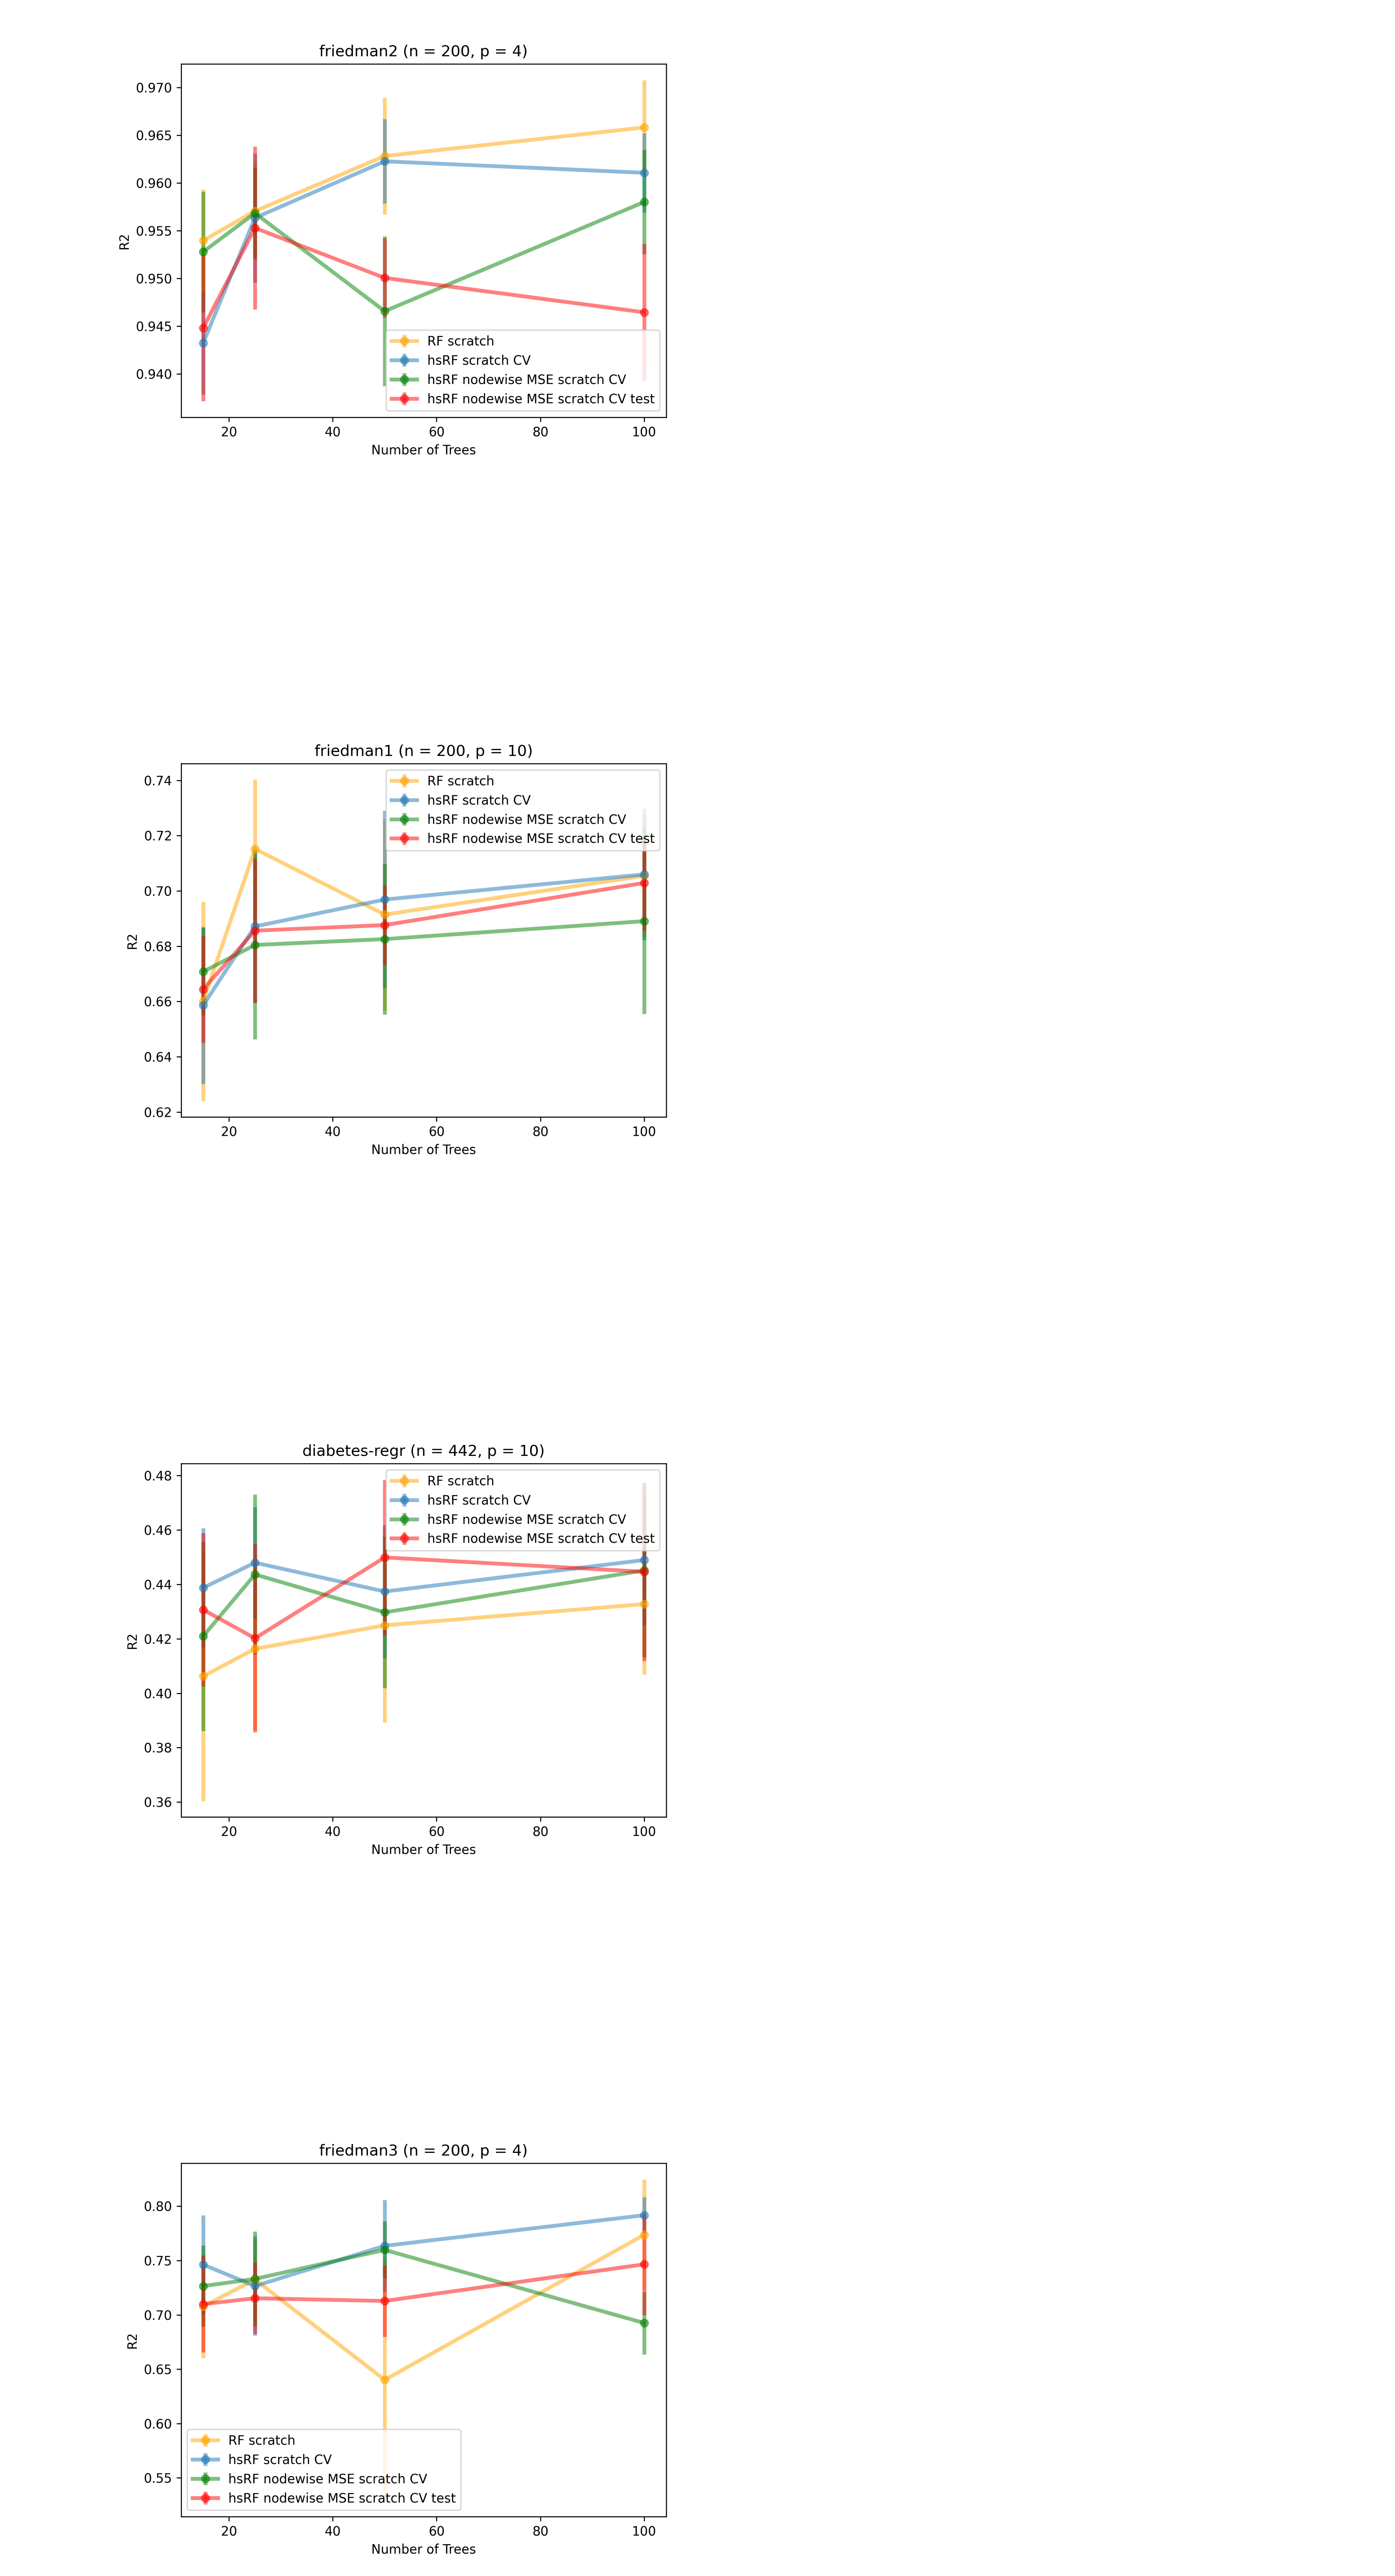

In [68]:
fig, axs = plt.subplots(len(imgs),1, figsize=(20,40))

axs = axs.ravel()

for ax, img_path in zip(axs, imgs):
    img = mpimg.imread(img_path)
    ax.imshow(img)
    ax.axis('off')



No clear performance improvement

## Load performance test results for inital version of MSE nodewise (with NaNs)

In [69]:
import matplotlib.image as mpimg
data_path = os.path.join(os.path.dirname(os.getcwd()),"data","HS_performance", "regression")
imgs = []
valid_images = [".jpg",".gif",".png",".tga"]

for f in os.listdir(data_path):
    ixt = os.path.splitext(f)[0]
    ext = os.path.splitext(f)[1]
    if (ext.lower() not in valid_images) or (ixt[:8]!="20221125"):
        continue
    imgs.append(os.path.join(data_path,f))

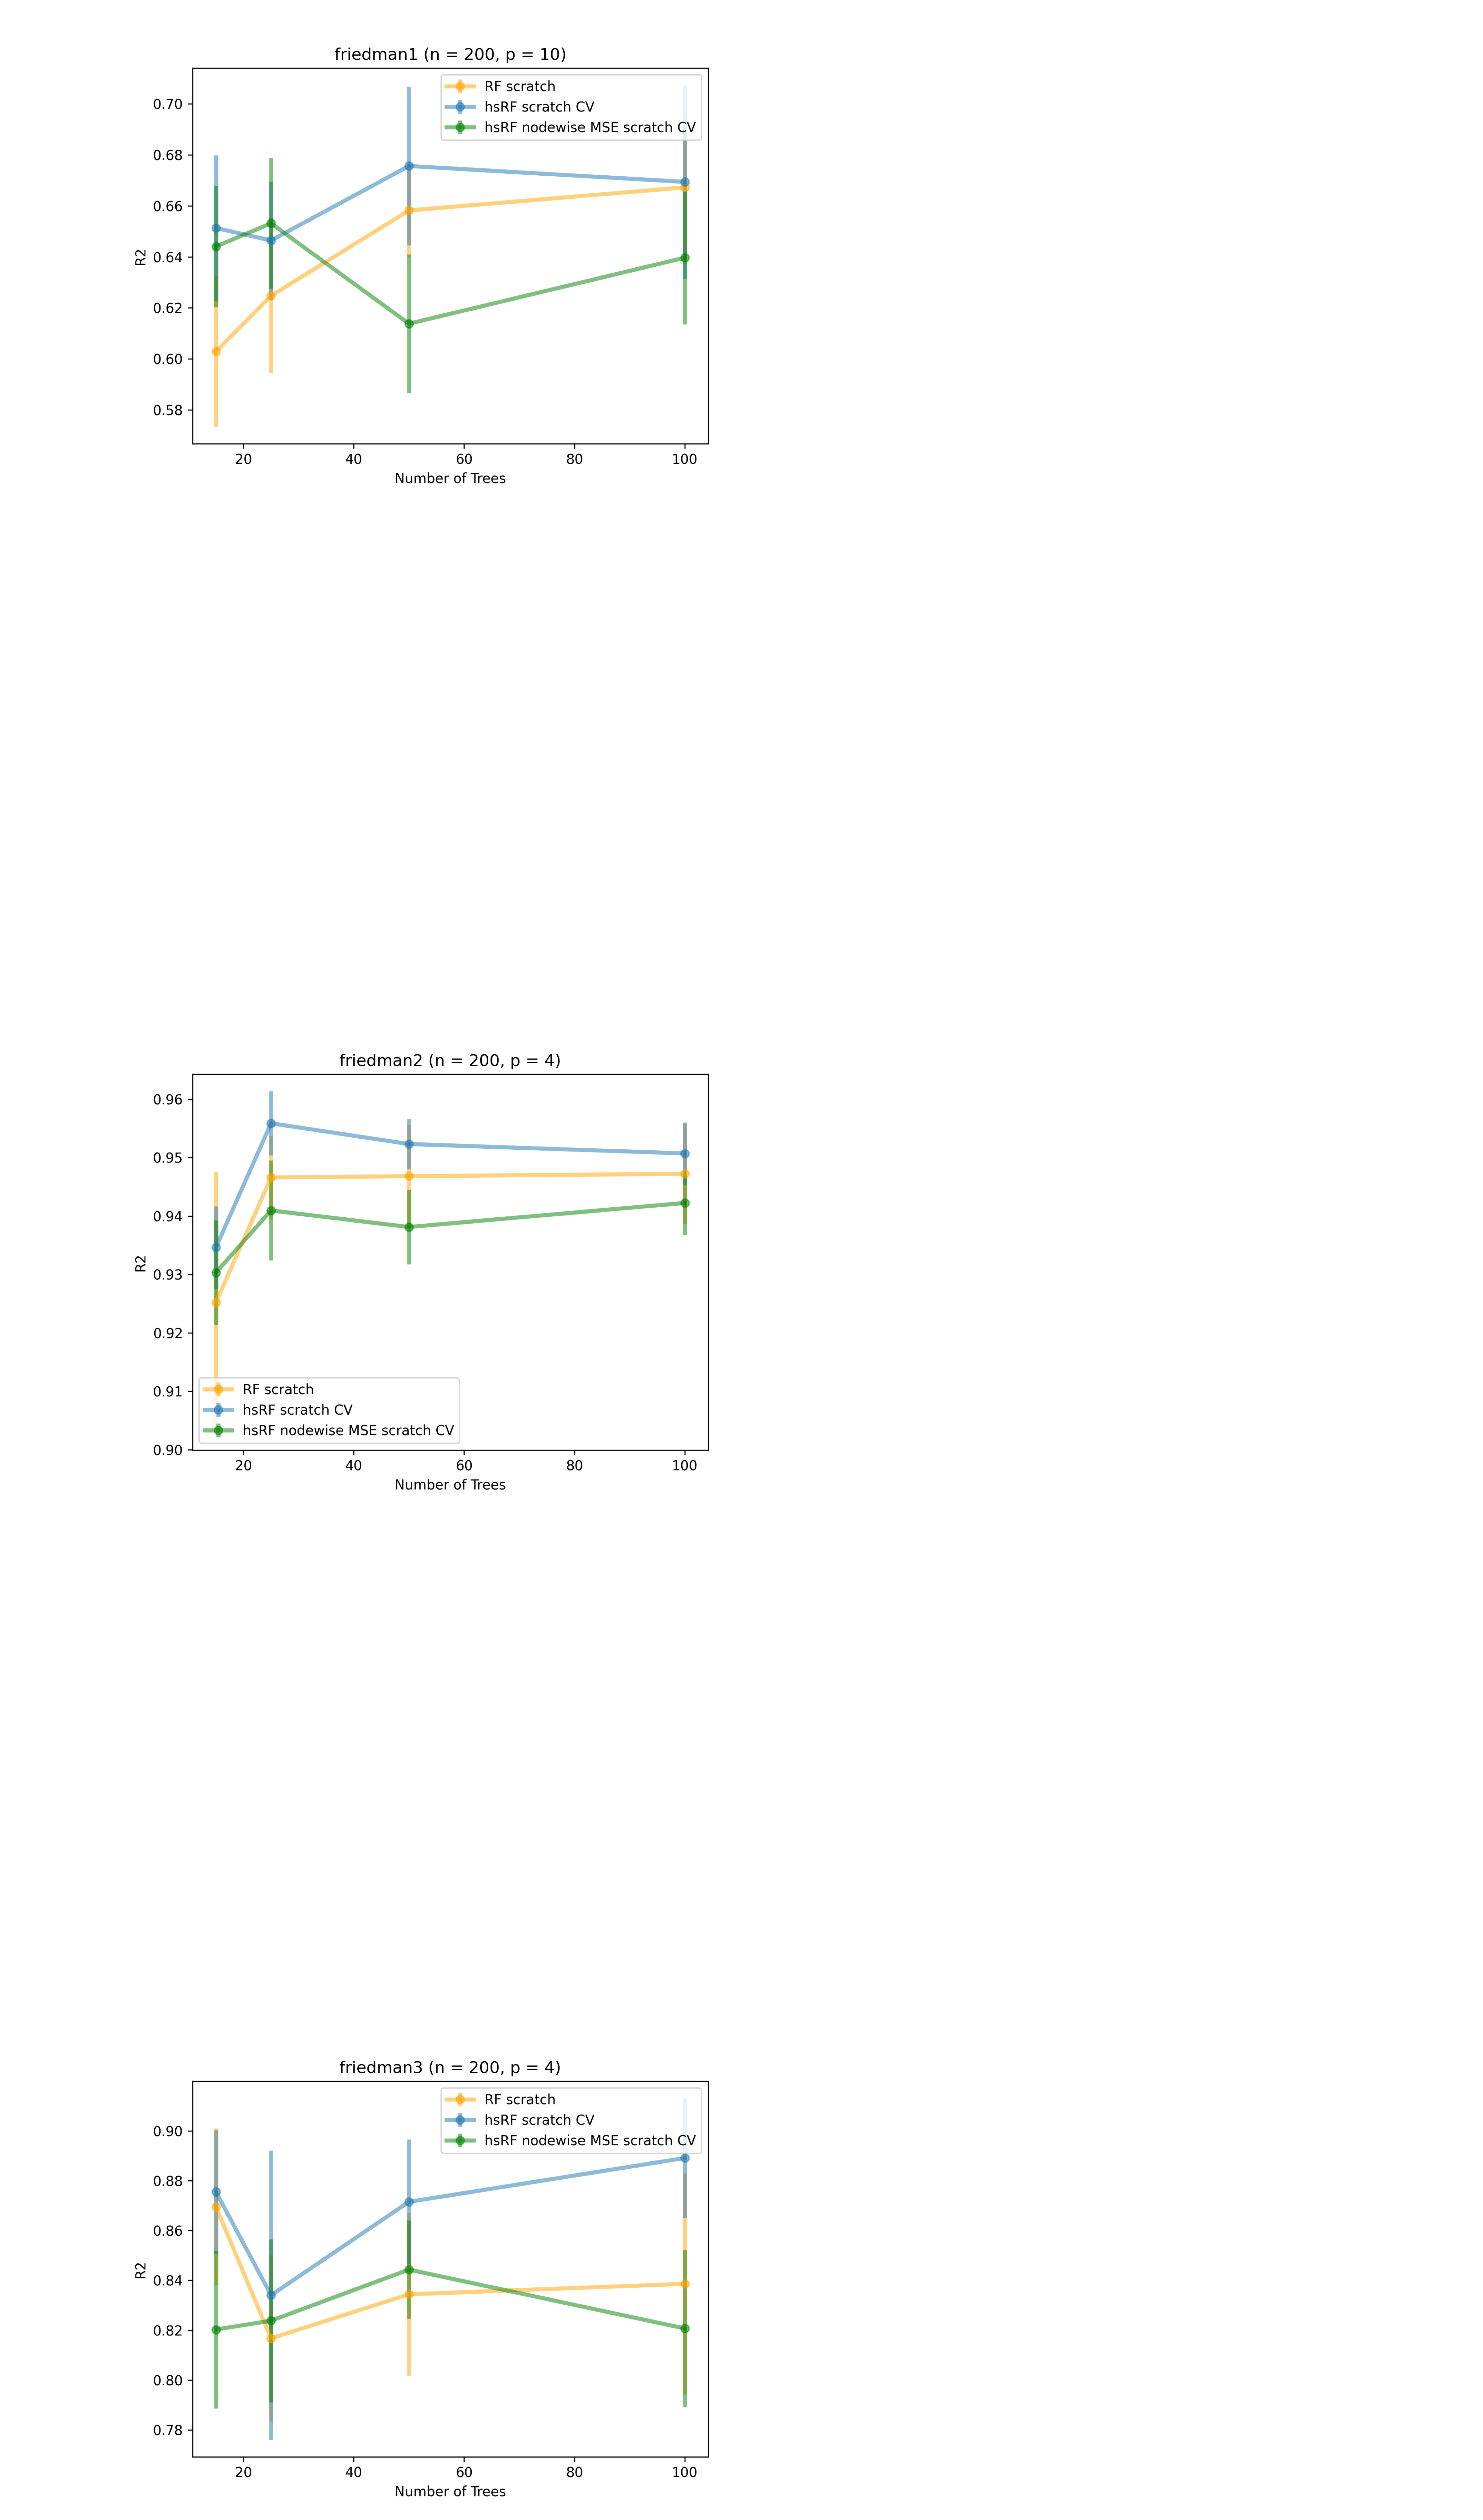

In [70]:
fig, axs = plt.subplots(len(imgs),1, figsize=(20,40))

axs = axs.ravel()

for ax, img_path in zip(axs, imgs):
    img = mpimg.imread(img_path)
    ax.imshow(img)
    ax.axis('off')



Hard to compare to results from idea 2 & 3 as the results (even from the original RF and HSRF differ significantly)